# RTF Model for predicting zone with Peaks

Import

In [35]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Readwav function

In [36]:
def readWavFolder(folderPath):
    fileFolder=[]
    sampleRateFolder=[]

    files = os.listdir(folderPath)
    for filename in glob.glob(os.path.join(folderPath, '*.wav')):
        samplerate, data = wavfile.read(filename)
        fileFolder.append(data)
        sampleRateFolder.append(samplerate)
    return sampleRateFolder, fileFolder, files
    
samplerateVect,testWavFileVect,filename = readWavFolder("../../Data_Clean/new_RB")


Spectrum

In [37]:
def spectrumFromWav(wavFile):
    spectrum = fft(wavFile[:, 1])  # Compute the FFT for the first channel
    return abs(spectrum[:len(spectrum) // 2])  # Return the magnitude of the spectrum (half due to symmetry)

Extract each peak and store

In [38]:
def extractNPeak(n_peak,signal):
    # Find peaks in the signal
    peaks = np.argsort(signal)[-n_peak:]  # Get indices of the n largest peaks
    peaks = np.sort(peaks)  # Sort the indices in ascending order

    # Extract the peak values
    peak_values = signal[peaks]

    return peaks, peak_values


# Fonction pour lire les fichiers d'un dossier donné
def lire_fichiers_dossier(dossier):
    if os.path.exists(dossier):  # Vérifier si le dossier existe
        return readWavFolder(dossier)
    else:
        print(f"Dossier introuvable : {dossier}")
        return [], [], []  # Retourne des listes vides si le dossier n'existe pas


## Main

In [39]:
# Liste des types de raquettes et zones
raquetteTypeList = {"RB":0, "RO":1, "RR":2, "RV":3}
racket_ages = {"P1":1, "P2":2, "P3":3}

allWavFile=[]
allWavFileLabel=[]
allWavFileP1=[]
allWavFileP2=[]
allWavFileP3=[]

#P1
for raquetteType in raquetteTypeList:
    sampleRateFolderP1_type,fileFolderP1,filesP1 = readWavFolder("../../Data_Clean/new_"+raquetteType)
    allWavFileP1.extend(fileFolderP1)

#P2
sampleRateFolderP2,allWavFileP2,filesP2 =readWavFolder("../../Data_Clean/Free_Condition/P2")

#P3
sampleRateFolderP3,allWavFileP3,filesP3 =readWavFolder("../../Data_Clean/Free_Condition/P3")


# Find the minimum length among the three lists
min_len = min(len(allWavFileP1), len(allWavFileP2), len(allWavFileP3))

# Reduce each list to the minimum length
allWavFileP1 = allWavFileP1[:min_len]
allWavFileP2 = allWavFileP2[:min_len]
allWavFileP3 = allWavFileP3[:min_len]

print("Len(allWavFileP1)",len(allWavFileP1),"Len(allWavFileP2)",len(allWavFileP2),"Len(allWavFileP3)",len(allWavFileP3))


# print(len(sampleRateFolderP1))

for wavFile in allWavFileP1:
    allWavFile.append(wavFile)
    allWavFileLabel.append("P1")
for wavFile in allWavFileP2:
    allWavFile.append(wavFile)
    allWavFileLabel.append("P2")
for wavFile in allWavFileP3:
    allWavFile.append(wavFile)
    allWavFileLabel.append("P3")

Len(allWavFileP1) 213 Len(allWavFileP2) 213 Len(allWavFileP3) 213


Extract peaks

In [40]:
bestPeakHZAllWavFile = []
bestPeakAmplitudeAllWavFile = []
n_peak = 25

for wavFile in allWavFile:
    # Compute the spectrum using FFT
    spectrum = spectrumFromWav(wavFile)

    # Extract peaks from the spectrum
    peaks_HZ, peak_Amplitude = extractNPeak(n_peak, spectrum)
    bestPeakHZAllWavFile.append(peaks_HZ)
    bestPeakAmplitudeAllWavFile.append(peak_Amplitude)

    # Normaliser les amplitudes
    bestPeakAmplitudeAllWavFile = [amp / np.max(amp) for amp in bestPeakAmplitudeAllWavFile]

In [41]:
# Combine features into X
X = np.hstack([np.array(bestPeakHZAllWavFile), np.array(bestPeakAmplitudeAllWavFile)])

# Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(allWavFileLabel)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Définir les bonnes valeurs trouvé
n_estimators_range = [10, 50, 100]
max_depth_range = [None, 10, 20, 30]
min_samples_split_range = [2, 5, 10]

results = []

# Tester toutes les combinaisons d'hyperparamètres
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        for min_samples_split in min_samples_split_range:
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            y_train_pred = rf.predict(X_train)

            results.append({
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'accuracy_train': accuracy_score(y_train, y_train_pred),
                'accuracy_test': accuracy_score(y_test, y_pred)
            })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)
print(results_df)

    n_estimators  max_depth  min_samples_split  accuracy_train  accuracy_test
0             10        NaN                  2        0.996086       0.953125
1             10        NaN                  5        0.988258       0.929688
2             10        NaN                 10        0.972603       0.929688
3             10       10.0                  2        0.996086       0.945312
4             10       10.0                  5        0.990215       0.929688
5             10       10.0                 10        0.972603       0.929688
6             10       20.0                  2        0.996086       0.953125
7             10       20.0                  5        0.988258       0.929688
8             10       20.0                 10        0.972603       0.929688
9             10       30.0                  2        0.996086       0.953125
10            10       30.0                  5        0.988258       0.929688
11            10       30.0                 10        0.972603  

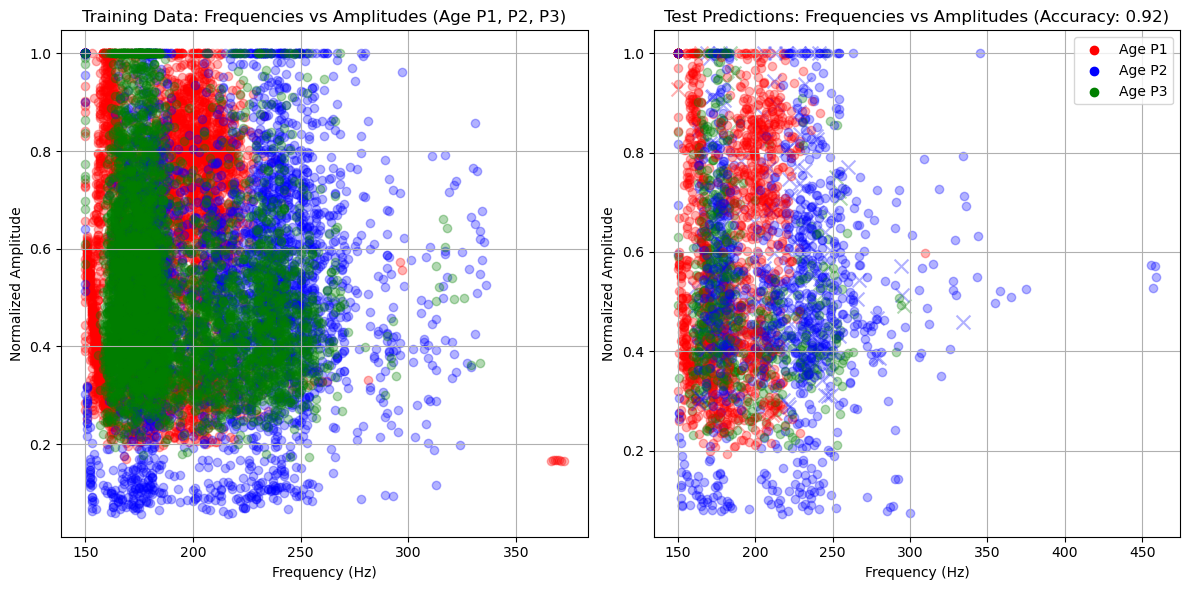

In [43]:
# Define a color map for the labels
colors = ['red', 'blue', 'green']
ageList = {"P1": 1, "P2": 2, "P3": 3}
label_names = list(ageList.keys())

# Create a scatter plot for the training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # First subplot for training data
for label_idx, label_name in enumerate(label_names):
    # Filter data points for the current label
    label_data = X_train[y_train == label_idx]
    for sample in label_data:
        # Add 150Hz because of the filter and filter frequencies <= 1250 Hz
        frequencies = sample[:n_peak] + 150
        amplitudes = sample[n_peak:]
        mask = frequencies <= 550
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[label_idx], alpha=0.3)

plt.title("Training Data: Frequencies vs Amplitudes (Age P1, P2, P3)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude")
plt.grid()

# Create a scatter plot for the test data with predictions
plt.subplot(1, 2, 2) # Second subplot for test data with predictions
y_pred = rf.predict(X_test) # Get predictions for test data

for i, sample in enumerate(X_test):
    true_label = y_test[i]
    pred_label = y_pred[i]

    # Add 150Hz because of the filter and filter frequencies <= 1250 Hz
    frequencies = sample[:n_peak] + 150
    amplitudes = sample[n_peak:]
    mask = frequencies <= 550

    # Plot with solid color if prediction is correct, otherwise use a different marker
    if true_label == pred_label:
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[pred_label], alpha=0.3)
    else:
        # Use 'x' marker for incorrect predictions
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[pred_label], marker='x', s=100, alpha=0.3)

# Add a legend
for label_idx, label_name in enumerate(label_names):
    plt.scatter([], [], color=colors[label_idx], label=f"Age {label_name}")

plt.legend()
plt.title(f"Test Predictions: Frequencies vs Amplitudes (Accuracy: {accuracy_score(y_test, y_pred):.2f})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

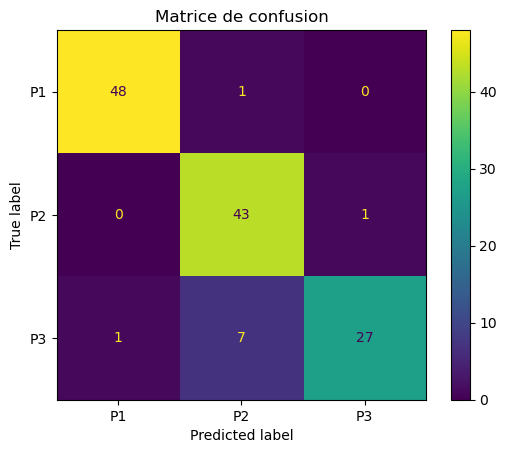

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()